In [11]:
import json

import matplotlib.pyplot as plt

from dataset.data_loaders import load_dataset, generate_datasets
from ESN import esnet
from sklearn.metrics import mean_squared_error

# Probabilistic time series forecasting with randomized neural networks

Author: Michele Guerra

Date: 18 November 2022

## Time series data

The data used for this seminar were provided by ACEA, an Italian energy distributor, and they represent the hourly generation (?) of electric energy.

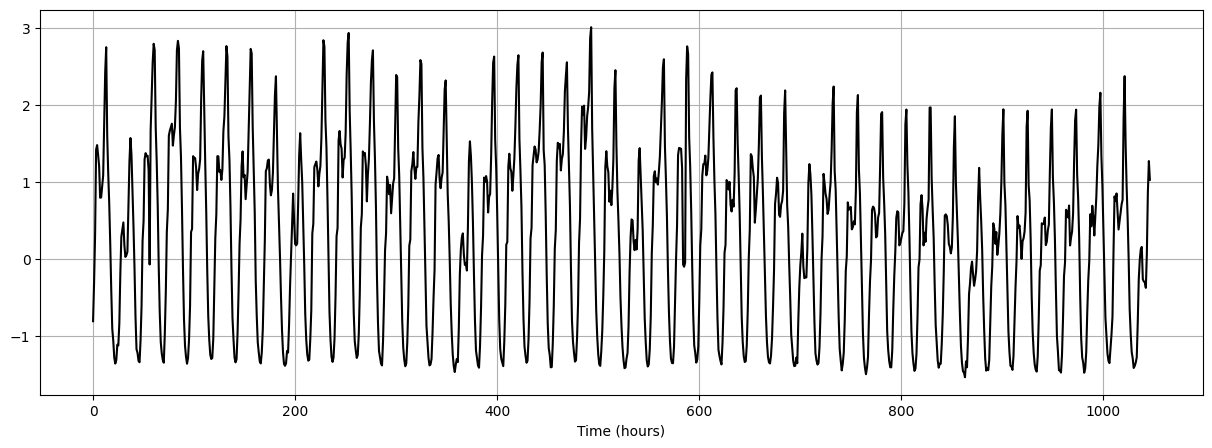

In [2]:
# Load and pre-process dataset
X, Y = load_dataset("acea")
Xtr, Ytr, Xval, Yval, Xte, Yte = generate_datasets(X, Y, test_percent = 0.15, val_percent = 0.15)

# Plot data
fig = plt.figure(figsize=(15,5))
plt.plot(Yte, color='k')
plt.grid()  
plt.xlabel("Time (hours)")
plt.show()

A typical problem with time series is the forecasting: given the amount of energy distributed now, can we predict how much will be needed tomorrow at the same time?

## Reservoir Computing and ESN

A Reservoir Computing is a Recurrent Neural Network (RNN) with some peculiar features. It consists of an input layer, a **reservoir** and an output layer.

Its peculiarity is that the only part subjected to training is the output layer, while all the weights of the input layer and, above all, of the reservoir, are fixed randomly at the beginning and never adgjusted afterwards.

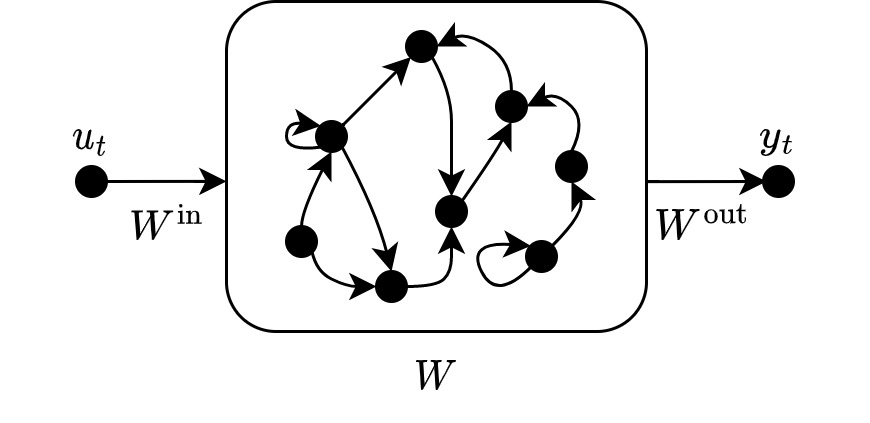

In formulae
$$
    x_{t+1}=f(Wx_t+W^\text{in}u_{t+1})
$$
$$
    y_t=g(W^\text{out}(x_t))
$$

An Echo State Network (ESN) is a Reservoir Computing that satisfies the Echo State Property: loosely speaking, it says that the reservoir dynamics will asymptotically lose dependency on the initial condition of its state.

Let's build an ESN with:
- $W$ is a $500\times 500$ matrix, 
- its elements are randomly and uniformly drawn in $(-0.5,+0.5)$,
- and it is *sparse*, with a connectivity of $25\%$.

The ESN transforms each input in the input time series into an embedding of dimension 20, and finally the output is produced by training a simple regression layer over those embeddings.

In [7]:
# Set ESN hyperparams
config = json.load(open('ESN/configs/ESN_hyperparams.json', 'r'))

# Train and compute embeddings and predictions
Yte_pred, _, _, train_embedding, _, val_embedding, _, test_embedding = esnet.run_from_config_return_states(Xtr, Ytr, 
                                                                                                            Xte, Yte, 
                                                                                                            config, 
                                                                                                            validation=True,
                                                                                                            Xval=Xval,
                                                                                                            Yval=Yval)

We can now plot the predictions produced by our ESN and compare them with the actual values provided by ACEA

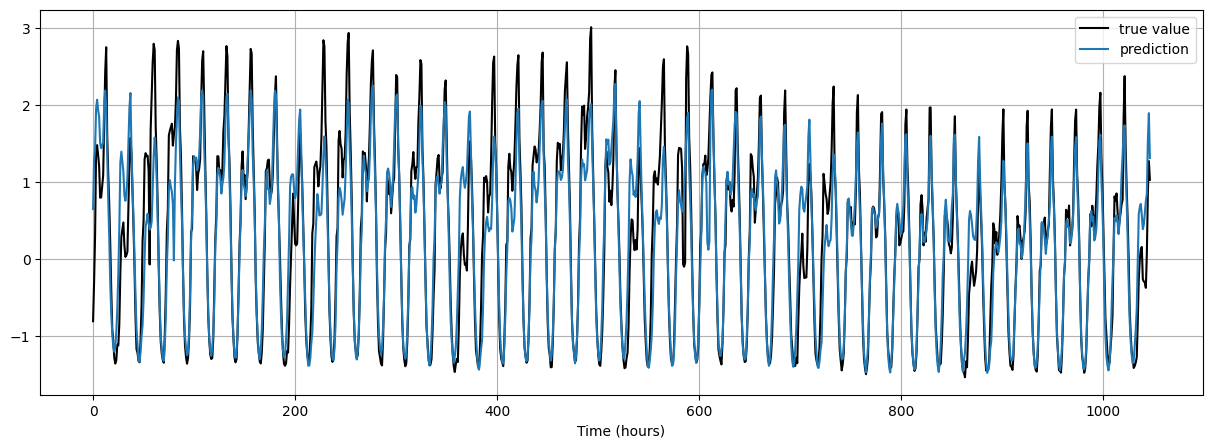

Test MSE 0.199


In [12]:
# Plot results
fig = plt.figure(figsize=(15,5))
plt.plot(Yte, label='true value', color='k')
plt.plot(Yte_pred, label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.xlabel("Time (hours)")
plt.show()

# Mean square error of the prediction
print('Test MSE {:.3f}'.format(mean_squared_error(Yte_pred, Yte)))

## Uncertainty

The ESN we trained above is making deterministic 24h forecasts, that is it produces a single output for each input we provide.

What if we pass to it an input that lies quite away from the data that it was trained with? It will still produce an output, but how do we know how likely that output is? In other words, how do we know how confident is our network when predicting that value?

There are two sources of **uncertainties** in Deep Learning:
- An **aleatoric uncertainty**, reflecting the noise coming from the data itself (if, for example, it comes from measurements).
- A **model uncertainty**, which arises in two possible ways:
    * an uncertainty related to model's parameters (for example, multiple models could explain the same dataset);
    * an uncertainty coming from the model's structure itself.
    
We want to quantify how much the above sources of uncertainty affect the prediction.

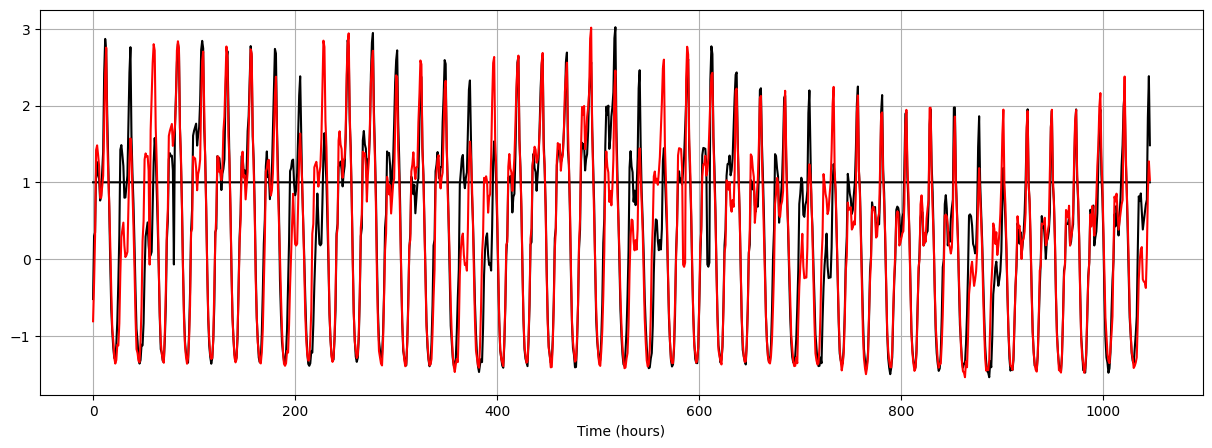

In [17]:
fig = plt.figure(figsize=(15,5))
plt.plot(Xte, color='k')
plt.plot(Yte, color='r')
plt.grid()  
plt.xlabel("Time (hours)")
plt.show()